## Part 2 - Data Cleaning
During our EDA we encountered some variables with incomplete or corrupted data.  
In this notebook we will use Pandas to:
* Remove outliers  
* Handle missing, null or corrupted values  

In [34]:
import os
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Preview the data 

In [35]:
data_dir = './data'
df_dirty = pd.read_csv(os.path.join(data_dir, 'data.csv'))
df_dirty.head() # display first 5 entries of DataFrame

,title,address,city,state,postal_code,price,facts and features,real estate provider,url,bed,bath,sqft,property_type,latlng
0,New Construction,288 Pacific Ave # 67UQRR,San Francisco,CA,94111,NaN,"-- bds , -- ba , -- sqft",NaN,https://www.zillow.com/community/288-pacific/2...,NaN,NaN,NaN,new,NaN
1,Condo For Sale,733 Front St UNIT 606,SAN FRANCISCO,CA,94111,1195000.0,"1 bd , 1 ba , 920 sqft",Climb Real Estate,https://www.zillow.com/homedetails/733-Front-S...,1.0,1.0,920.0,condo,NaN
2,Condo For Sale,101 Lombard St APT 401W,SAN FRANCISCO,CA,94111,1425000.0,"2 bds , 2 ba , 1,238 sqft",Paragon Real Estate Group,https://www.zillow.com/homedetails/101-Lombard...,2.0,2.0,1238.0,condo,NaN
3,Condo For Sale,111 Chestnut St UNIT 109,SAN FRANCISCO,CA,94111,1600000.0,"2 bds , 2 ba , 1,925 sqft",CENTURY 21 Real Estate Alliance,https://www.zillow.com/homedetails/111-Chestnu...,2.0,2.0,1925.0,condo,NaN
4,Lot/Land For Sale,1235 Sansome St,San Francisco,CA,94111,998000.0,"6,882 sqft lot",NaN,https://www.zillow.com/homedetails/1235-Sansom...,NaN,NaN,6882.0,lot,"(37.8015226190476, -122.402951)"


## Remove outliers
Recall from our EDA that our price data has outliers which result in high skewness and kurtosis values.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Skewness: 4.342407423821276
Kurtosis: 25.95613934429243


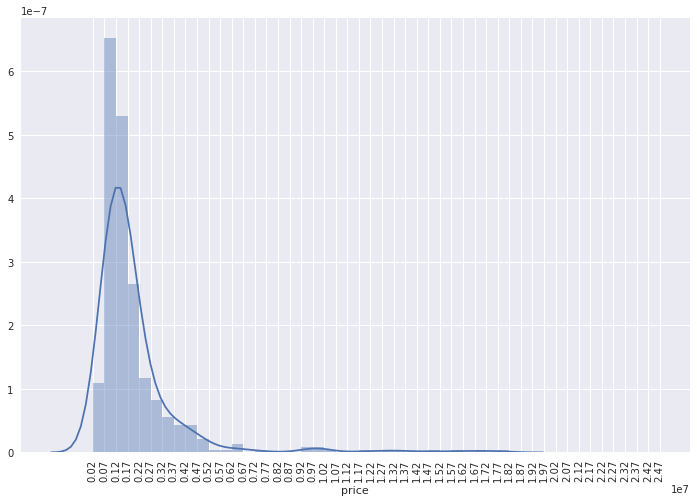

In [36]:
# globally set our seaborn plot size to 12 by 8 inches:
sns.set(rc={'figure.figsize':(12, 8)})

def plot_prices(dataframe: pd.DataFrame, bins: list):
    fig, ax = plt.subplots()
    ax.set_xticks(bins)
    plt.xticks(rotation='vertical')
    return sns.distplot(dataframe.price, bins=bins)

bins = range(int(df_dirty.price.min()),int(df_dirty.price.max()),500000)
bins
plot_prices(df_dirty.dropna(), bins)
print(f'Skewness: {df_dirty.price.skew()}')
print(f'Kurtosis: {df_dirty.price.kurt()}')

In [37]:
print(f'max price before: {df_dirty.price.max()}')
cutoff = 8e6
df_clean = df_dirty[df_dirty['price'] <= cutoff]
print(f'max price after: {df_clean.price.max()}')

max price before: 25000000.0
max price after: 8000000.0


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Skewness: 2.076076
Kurtosis: 4.896730


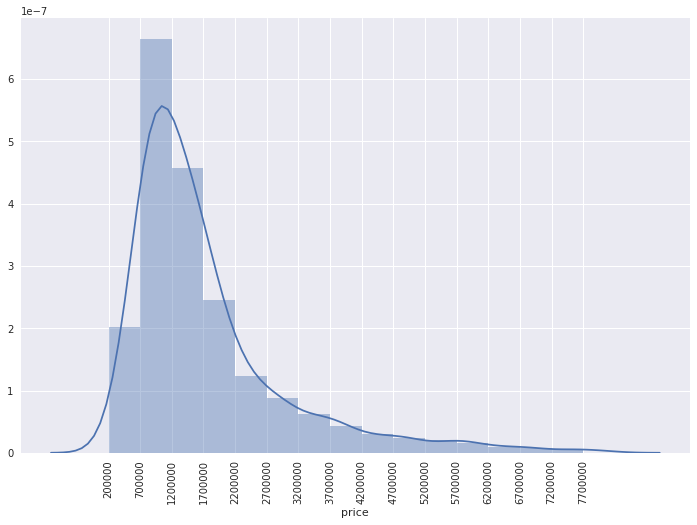

In [38]:
bins = range(int(df_clean.price.min()),int(df_clean.price.max()),500000)
plot_prices(df_clean, bins)
print("Skewness: %f" % df_clean['price'].skew())
print("Kurtosis: %f" % df_clean['price'].kurt())

The skewness and kurtosis values have improved. The distribution is still skewed however there are transformations we can apply to the dataset to make it more normally distributed. More on these transformations in a later notebook.

In [39]:
num_zero_sqft = (df_clean['sqft'] < 10).sum()
print("There are {} entries with zero sqft".format(num_zero_sqft))

There are 1 entries with zero sqft


In [40]:
df_clean = df_clean[df_clean['sqft'] > 10]
num_zero_sqft = (df_clean['sqft'] < 10).sum()
print("There are {} entries with zero sqft".format(num_zero_sqft))

There are 0 entries with zero sqft


There was also some `sqft` outliers at the very high range, let's rid ourselves of these values as well

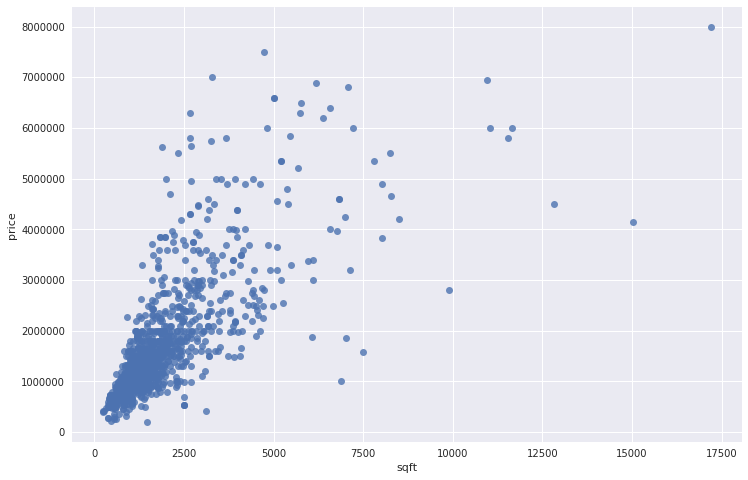

In [41]:
sns.regplot(df_clean['sqft'], df_clean['price'], fit_reg=False)

In [42]:
print(f'max sqft before: {df_clean.sqft.max()}')
df_clean = df_clean[df_clean['sqft'] < 9000]
print(f'max sqft after: {df_clean.sqft.max()}')

max sqft before: 17208.0
max sqft after: 8502.0


## Deal with Null and Missing values

In [43]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1120 entries, 1 to 1248
Data columns (total 14 columns):
title                   1120 non-null object
address                 1120 non-null object
city                    1120 non-null object
state                   1120 non-null object
postal_code             1120 non-null int64
price                   1120 non-null float64
facts and features      1120 non-null object
real estate provider    878 non-null object
url                     1120 non-null object
bed                     1103 non-null float64
bath                    961 non-null float64
sqft                    1120 non-null float64
property_type           1112 non-null object
latlng                  719 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 131.2+ KB


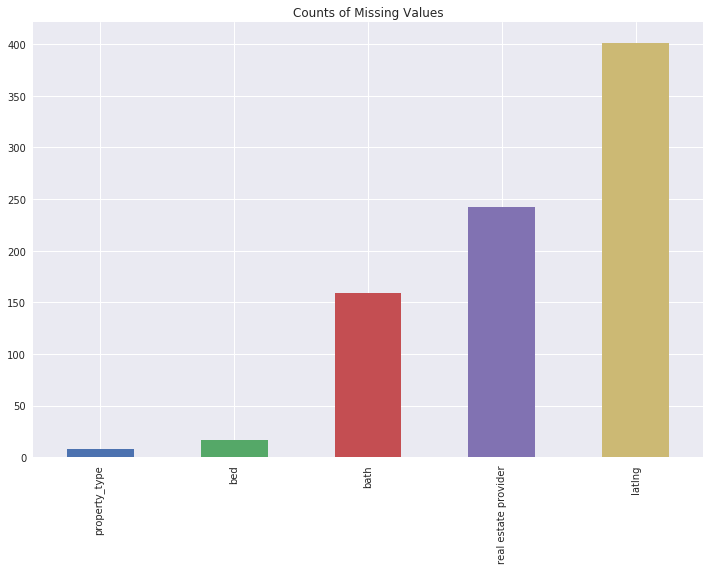

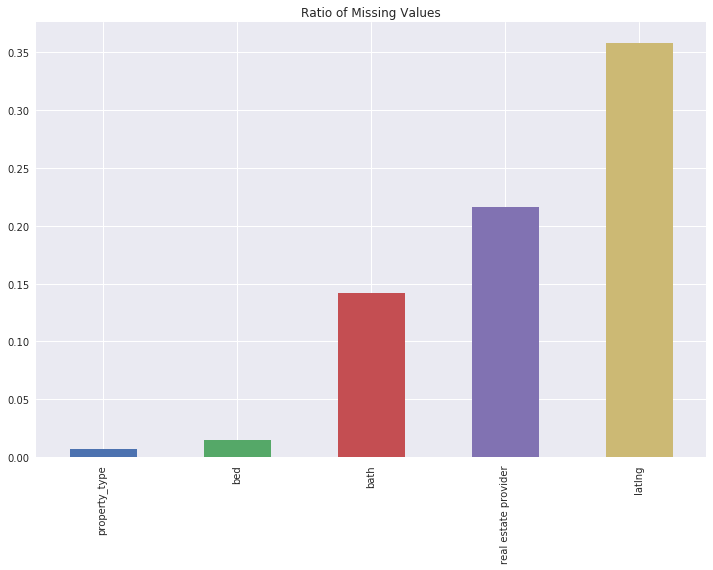

In [44]:
missing = df_clean.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()
plt.title("Counts of Missing Values")
plt.show()
missing_ratio = missing / len(df_clean)
missing_ratio.plot.bar()
plt.title("Ratio of Missing Values")
plt.show()

First, we will choose to remove the `latlng` column completely. Although there may be some use cases for this data (eg. find distance to nearby schools, parks, etc.) we will remove it and keep the `postal_code` column as our location data.  
We will also remove `real estate provider` since there are too many unique values.

In [45]:
print(df_clean.columns)
df_clean = df_clean.drop(columns=['latlng', 'real estate provider'])
print(df_clean.columns)

Index(['title', 'address', 'city', 'state', 'postal_code', 'price',
       'facts and features', 'real estate provider', 'url', 'bed', 'bath',
       'sqft', 'property_type', 'latlng'],
      dtype='object')
Index(['title', 'address', 'city', 'state', 'postal_code', 'price',
       'facts and features', 'url', 'bed', 'bath', 'sqft', 'property_type'],
      dtype='object')


Now we could choose to drop all rows with null/missing values with `df.dropna()`, but we may benefit from "imputing" these values instead:  

**Imputation** fills in the missing value with some number. The imputed value won't be exactly right in most cases, but it usually gives more accurate models than dropping the column entirely.

In [46]:
df_clean_dropna = df_clean.dropna()

In [47]:
df_clean_dropna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 948 entries, 1 to 1248
Data columns (total 12 columns):
title                 948 non-null object
address               948 non-null object
city                  948 non-null object
state                 948 non-null object
postal_code           948 non-null int64
price                 948 non-null float64
facts and features    948 non-null object
url                   948 non-null object
bed                   948 non-null float64
bath                  948 non-null float64
sqft                  948 non-null float64
property_type         948 non-null object
dtypes: float64(4), int64(1), object(7)
memory usage: 96.3+ KB


In [48]:
from sklearn.preprocessing import Imputer
df_clean_imputed = df_clean.copy() # copy original for safe keeping
columns_to_impute = ['bed', 'bath', 'sqft'] # only impute numerical columns
imputer = Imputer(strategy='mean')
imputed_columns = imputer.fit_transform(df_clean_imputed[columns_to_impute])
df_clean_imputed[columns_to_impute] = imputed_columns
df_clean_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1120 entries, 1 to 1248
Data columns (total 12 columns):
title                 1120 non-null object
address               1120 non-null object
city                  1120 non-null object
state                 1120 non-null object
postal_code           1120 non-null int64
price                 1120 non-null float64
facts and features    1120 non-null object
url                   1120 non-null object
bed                   1120 non-null float64
bath                  1120 non-null float64
sqft                  1120 non-null float64
property_type         1112 non-null object
dtypes: float64(4), int64(1), object(7)
memory usage: 113.8+ KB


Now that we have imputed all of the values we can, let's drop the rest of the rows containing null values

In [49]:
df_clean_imputed = df_clean_imputed.dropna()

In [50]:
df_clean_imputed = df_clean_imputed[df_clean_imputed.postal_code != 94501] 

In [51]:
df_clean_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1112 entries, 1 to 1248
Data columns (total 12 columns):
title                 1112 non-null object
address               1112 non-null object
city                  1112 non-null object
state                 1112 non-null object
postal_code           1112 non-null int64
price                 1112 non-null float64
facts and features    1112 non-null object
url                   1112 non-null object
bed                   1112 non-null float64
bath                  1112 non-null float64
sqft                  1112 non-null float64
property_type         1112 non-null object
dtypes: float64(4), int64(1), object(7)
memory usage: 112.9+ KB


 ## Save the dataframes to .csv

In [52]:
df_clean_dropna.to_csv(os.path.join(data_dir, 'data_clean_dropna.csv'), index=False)
df_clean_imputed.to_csv(os.path.join(data_dir, 'data_clean_imputed.csv'), index=False)